In [2]:
!pip install biokit
!pip install dcor
import dcor
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import sklearn as sk
import os
import math
import time
import seaborn as sns
sns.set()
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker
%matplotlib inline
from patsy import dmatrices, dmatrix
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from biokit.viz import corrplot
import warnings; warnings.simplefilter('ignore')
from joblib import Parallel, delayed



In [0]:
# Load Dataset from GDrive

!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
# This only needs to be done once per notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)


# Download a file based on its file ID.
# Master Data
file_id_1 = '1OlsxUea7sPoaV0YcfyqNLAX4vV6ZLh6e'
downloaded_1 = drive.CreateFile({'id': file_id_1})
downloaded_1.GetContentFile('netflixdata.csv')


file_id_1 = '1YK4yO9uAWMx4_zaay_bktMjZ1sytYHoS'
downloaded_1 = drive.CreateFile({'id': file_id_1})
downloaded_1.GetContentFile('masterdata.csv')





In [4]:
#read the dataset
netflixdata = pd.read_csv('netflixdata.csv')
netflixdata = netflixdata.head(1000000)
netflixdata.info()
#data.head(10)
master_data = pd.read_csv('masterdata.csv')
master_data.info()
#data2.head(10)

#netflixdata = DataFrame.from_csv('netflix_data.csv', sep=",")





<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 7 columns):
Unnamed: 0     1000000 non-null int64
movie_id       1000000 non-null int64
year           1000000 non-null float64
movie_name     1000000 non-null object
customer_id    1000000 non-null int64
rating         1000000 non-null float64
date           1000000 non-null object
dtypes: float64(2), int64(3), object(2)
memory usage: 53.4+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2270533 entries, 0 to 2270532
Data columns (total 28 columns):
tconst                                    object
titleType                                 object
primaryTitle                              object
originalTitle                             object
isAdult                                   int64
startYear                                 float64
endYear                                   object
runtimeMinutes                            object
genres                                    object


In [5]:
netflixdata = pd.merge(netflixdata, master_data, how='inner', left_on=['movie_name'], right_on=['primaryTitle'])
netflixdata.head(10)

,Unnamed: 0,movie_id,year,movie_name,customer_id,rating,date,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres,directors,writers,"('primaryName', 'actor')","('primaryName', 'actress')","('primaryName', 'archive_footage')","('primaryName', 'archive_sound')","('primaryName', 'cinematographer')","('primaryName', 'composer')","('primaryName', 'director')","('primaryName', 'editor')","('primaryName', 'producer')","('primaryName', 'production_designer')","('primaryName', 'self')","('primaryName', 'writer')",averageRating,numVotes,Genre1,Genre2,Genre3
0,0,1,2003.0,Dinosaur Planet,1567328,4.0,2005-02-16,tt0389605,tvMiniSeries,Dinosaur Planet,Dinosaur Planet,0,2003.0,\N,50,"Animation,Documentary,Family",nm0504273,"nm4178464,nm4177463,nm0989448,nm0647431,nm0662263",Christian Slater,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Scott Sampson,NaN,7.7,411.0,Animation,Documentary,Family
1,1,1,2003.0,Dinosaur Planet,2091010,4.0,2005-02-10,tt0389605,tvMiniSeries,Dinosaur Planet,Dinosaur Planet,0,2003.0,\N,50,"Animation,Documentary,Family",nm0504273,"nm4178464,nm4177463,nm0989448,nm0647431,nm0662263",Christian Slater,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Scott Sampson,NaN,7.7,411.0,Animation,Documentary,Family
2,2,1,2003.0,Dinosaur Planet,2537219,4.0,2005-04-01,tt0389605,tvMiniSeries,Dinosaur Planet,Dinosaur Planet,0,2003.0,\N,50,"Animation,Documentary,Family",nm0504273,"nm4178464,nm4177463,nm0989448,nm0647431,nm0662263",Christian Slater,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Scott Sampson,NaN,7.7,411.0,Animation,Documentary,Family
3,3,1,2003.0,Dinosaur Planet,2625420,2.0,2004-11-01,tt0389605,tvMiniSeries,Dinosaur Planet,Dinosaur Planet,0,2003.0,\N,50,"Animation,Documentary,Family",nm0504273,"nm4178464,nm4177463,nm0989448,nm0647431,nm0662263",Christian Slater,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Scott Sampson,NaN,7.7,411.0,Animation,Documentary,Family
4,4,1,2003.0,Dinosaur Planet,955896,5.0,2005-11-28,tt0389605,tvMiniSeries,Dinosaur Planet,Dinosaur Planet,0,2003.0,\N,50,"Animation,Documentary,Family",nm0504273,"nm4178464,nm4177463,nm0989448,nm0647431,nm0662263",Christian Slater,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Scott Sampson,NaN,7.7,411.0,Animation,Documentary,Family
5,5,1,2003.0,Dinosaur Planet,735894,4.0,2005-07-19,tt0389605,tvMiniSeries,Dinosaur Planet,Dinosaur Planet,0,2003.0,\N,50,"Animation,Documentary,Family",nm0504273,"nm4178464,nm4177463,nm0989448,nm0647431,nm0662263",Christian Slater,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Scott Sampson,NaN,7.7,411.0,Animation,Documentary,Family
6,6,1,2003.0,Dinosaur Planet,985334,5.0,2005-09-12,tt0389605,tvMiniSeries,Dinosaur Planet,Dinosaur Planet,0,2003.0,\N,50,"Animation,Documentary,Family",nm0504273,"nm4178464,nm4177463,nm0989448,nm0647431,nm0662263",Christian Slater,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Scott Sampson,NaN,7.7,411.0,Animation,Documentary,Family
7,7,1,2003.0,Dinosaur Planet,354278,4.0,2005-06-16,tt0389605,tvMiniSeries,Dinosaur Planet,Dinosaur Planet,0,2003.0,\N,50,"Animation,Documentary,Family",nm0504273,"nm4178464,nm4177463,nm0989448,nm0647431,nm0662263",Christian Slater,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Scott Sampson,NaN,7.7,411.0,Animation,Documentary,Family
8,8,1,2003.0,Dinosaur Planet,1843617,3.0,2004-08-18,tt0389605,tvMiniSeries,Dinosaur Planet,Dinosaur Planet,0,2003.0,\N,50,"Animation,Documentary,Family",nm0504273,"nm4178464,nm4177463,nm0989448,nm0647431,nm0662263",Christian Slater,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Scott Sampson,NaN,7.7,411.0,Animation,Documentary,Family
9,9,1,2003.0,Dinosaur Planet,2432108,5.0,2004-11-29,tt0389605,tvMiniSeries,Dinosaur Planet,Dinosaur Planet,0,2003.0,\N,50,"Animation,Documentary,Family",nm0504273,"nm4178464,nm4177463,nm0989448,nm0647431,nm0662263",Christian Slater,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Scott Sampson,NaN,7.7,411.0,Animation,Documentary,Family


In [6]:
data = netflixdata
data.describe()

,Unnamed: 0,movie_id,year,customer_id,rating,isAdult,startYear,averageRating,numVotes
count,1.798792e+06,1.798792e+06,1.798792e+06,1.798792e+06,1.798792e+06,1.798792e+06,1.798792e+06,1.071116e+06,1.071116e+06
mean,5.765948e+05,1.286057e+02,1.974449e+03,1.322744e+06,3.519397e+00,2.501179e-02,1.968796e+03,6.848900e+00,1.142581e+04
std,2.520853e+05,5.411475e+01,2.077066e+01,7.644760e+05,1.046786e+00,1.561608e-01,2.852125e+01,9.586567e-01,5.119818e+04
min,0.000000e+00,1.000000e+00,1.939000e+03,6.000000e+00,1.000000e+00,0.000000e+00,1.908000e+03,1.600000e+00,5.000000e+00
25%,2.983148e+05,7.100000e+01,1.957000e+03,6.604210e+05,3.000000e+00,0.000000e+00,1.951000e+03,6.400000e+00,3.800000e+01
50%,6.346780e+05,1.610000e+02,1.975000e+03,1.318179e+06,4.000000e+00,0.000000e+00,1.974000e+03,6.800000e+00,4.420000e+02
75%,8.079740e+05,1.710000e+02,1.995000e+03,1.984727e+06,4.000000e+00,0.000000e+00,1.993000e+03,7.600000e+00,4.631000e+03
max,9.618800e+05,2.130000e+02,2.005000e+03,2.649429e+06,5.000000e+00,1.000000e+00,2.005000e+03,9.400000e+00,8.366650e+05


In [7]:
len(data)

1798792

In [8]:
data['primaryTitle'].nunique()

135

In [0]:
user_rating_cnt = data.groupby(['customer_id']).count()[['movie_id']]

In [9]:
user_rating_cnt.head()

,movie_id
customer_id,
6,44
7,54
8,4
10,14
25,2


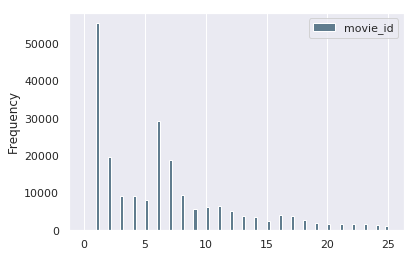

In [11]:
import matplotlib.pyplot as plt
# Histogram on # of ratings per user
user_rating_cnt.plot.hist(grid=True, bins=100,color='#607c8e', range=[0, 25])
plt.grid(axis='y')

In [0]:
grouped_data = data.groupby(['customer_id'])

In [0]:
users_morethan_1rating = grouped_data.filter(lambda x: len(x) > 1)

In [0]:
user_rating_cnt2 = users_morethan_1rating.groupby(['customer_id']).count()[['movie_id']]

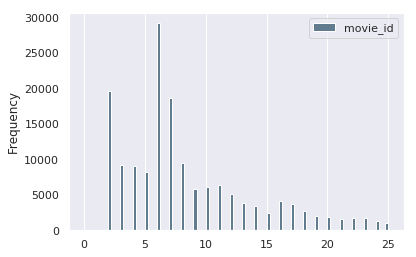

In [15]:
user_rating_cnt2.plot.hist(grid=True, bins=100,color='#607c8e', range=[0, 25])
plt.grid(axis='y')

In [16]:
#Count total users
len(user_rating_cnt2)

170010

In [17]:
#Count total reviews
len(users_morethan_1rating)

1743346

In [0]:
#Begin Feature Engineering
#Create basic customer history columns

#Genres watched and average rating for each genre

data2 = users_morethan_1rating
list(data2)

['movie_id',
 'year',
 'movie_name',
 'customer_id',
 'rating',
 'date',
 'tconst',
 'titleType',
 'primaryTitle',
 'originalTitle',
 'isAdult',
 'startYear',
 'endYear',
 'runtimeMinutes',
 'genres',
 'directors',
 'writers',
 "('primaryName', 'actor')",
 "('primaryName', 'actress')",
 "('primaryName', 'archive_footage')",
 "('primaryName', 'archive_sound')",
 "('primaryName', 'cinematographer')",
 "('primaryName', 'composer')",
 "('primaryName', 'director')",
 "('primaryName', 'editor')",
 "('primaryName', 'producer')",
 "('primaryName', 'production_designer')",
 "('primaryName', 'self')",
 "('primaryName', 'writer')",
 'averageRating',
 'numVotes']

In [0]:
data2.head()

,movie_id,year,movie_name,customer_id,rating,date,tconst,titleType,primaryTitle,originalTitle,...,"('primaryName', 'editor')","('primaryName', 'producer')","('primaryName', 'production_designer')","('primaryName', 'self')","('primaryName', 'writer')",averageRating,numVotes,Genre1,Genre2,Genre3
0,1,2003.0,Dinosaur Planet,1488844,3.0,2005-09-06,tt0389605,tvMiniSeries,Dinosaur Planet,Dinosaur Planet,...,NaN,NaN,NaN,Scott Sampson,NaN,7.7,411.0,Animation,Documentary,Family
2,1,2003.0,Dinosaur Planet,885013,4.0,2005-10-19,tt0389605,tvMiniSeries,Dinosaur Planet,Dinosaur Planet,...,NaN,NaN,NaN,Scott Sampson,NaN,7.7,411.0,Animation,Documentary,Family
3,1,2003.0,Dinosaur Planet,30878,4.0,2005-12-26,tt0389605,tvMiniSeries,Dinosaur Planet,Dinosaur Planet,...,NaN,NaN,NaN,Scott Sampson,NaN,7.7,411.0,Animation,Documentary,Family
4,1,2003.0,Dinosaur Planet,823519,3.0,2004-05-03,tt0389605,tvMiniSeries,Dinosaur Planet,Dinosaur Planet,...,NaN,NaN,NaN,Scott Sampson,NaN,7.7,411.0,Animation,Documentary,Family
5,1,2003.0,Dinosaur Planet,893988,3.0,2005-11-17,tt0389605,tvMiniSeries,Dinosaur Planet,Dinosaur Planet,...,NaN,NaN,NaN,Scott Sampson,NaN,7.7,411.0,Animation,Documentary,Family


In [0]:
type(data2)

pandas.core.frame.DataFrame

In [0]:
#Genres are comma separated and concatenated, split them
genres = data2.genres.str.split(',', expand=True)

In [0]:
#Put each into its own column
data2['Genre1'] = genres[0]
data2['Genre2'] = genres[1]
data2['Genre3'] = genres[2]

In [0]:
#Pivot Genre1, then Genre2, then Genre3
#to normalize data (column for each genre with a rating inside)
#Stack them via union afterwards
a=pd.pivot_table(data2,index=["customer_id","movie_id",'primaryTitle',"year",'date','titleType','isAdult','startYear','runtimeMinutes','directors','writers',"('primaryName', 'actor')","('primaryName', 'actress')",'numVotes','averageRating'],columns=['Genre1'],values='rating')
b=pd.pivot_table(data2,index=["customer_id","movie_id",'primaryTitle',"year",'date','titleType','isAdult','startYear','runtimeMinutes','directors','writers',"('primaryName', 'actor')","('primaryName', 'actress')",'numVotes','averageRating'],columns=['Genre2'],values='rating')
c=pd.pivot_table(data2,index=["customer_id","movie_id",'primaryTitle',"year",'date','titleType','isAdult','startYear','runtimeMinutes','directors','writers',"('primaryName', 'actor')","('primaryName', 'actress')",'numVotes','averageRating'],columns=['Genre3'],values='rating')

In [0]:
final_df = pd.concat([a, b], axis=0)

C:\Users\u339437\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


In [0]:
final_df = pd.concat([final_df, c], axis=0)

C:\Users\u339437\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


In [0]:
len(final_df)

1594751

In [0]:
final_df2.iloc[5,1]

83

In [0]:
final_df.sort_values(by=['customer_id','movie_id','year'])

Action  \
customer_id movie_id primaryTitle           year   date       titleType isAdult startYear runtimeMinutes directors writers                                           ('primaryName', 'actor')                  ('primaryName', 'actress')        numVotes averageRating           
6           30       Something's Gotta Give 2003.0 2004-09-15 movie     0.0     2003.0    128            nm0583600 nm0583600                                         Jack Nicholson,Keanu Reeves               Diane Keaton,Amanda Peet          104322.0 6.7               NaN   
                                                                                                                                                                                                                                                          6.7               NaN   
                                                                                                                                                                                                                                                          6.7               NaN   
            191      X2: X-Men United       2003.0 2004-11-24 movie     0.0     2003.0    134            nm0001741 nm0672015,nm0371684,nm0001741,nm1002424,nm0003529 Patrick Stewart,Hugh Jackman,Ian McKellen Halle Berry                       485400.0 7.4               2.0   
                                                                                                                                                                                                                                                          7.4               NaN   
                                                                                                                                                                                                                                                          7.4               NaN   
            197      Taking Lives           2004.0 2004-09-22 movie     0.0     2004.0    103.0          nm0142286 nm1373865,nm0092578                               Ethan Hawke,Kiefer Sutherland             Angelina Jolie,Gena Rowlands      75384.0  6.2               NaN   
                                                                                                                                                                                                                                                          6.2               NaN   
                                                                                                                                                                                                                                                          6.2               NaN   
7           28       Lilo and Stitch        2002.0 2005-05-23 tvEpisode 0.0     2002.0    \N             nm1742493 \N                                                Mike Johnson                              Alyson Stoner                     20.0     9.1               NaN   
            30       Something's Gotta Give 2003.0 2004-09-27 movie     0.0     2003.0    128            nm0583600 nm0583600                                         Jack Nicholson,Keanu Reeves               Diane Keaton,Amanda Peet          104322.0 6.7               NaN   
                                                                                                                                                                                                                                                          6.7               NaN   
                                                                                                                                                                                                                                                          6.7               NaN   
            83       Silkwood               1983.0 2005-10-30 movie     0.0     1983.0    131            nm0001566 nm0001188,nm0035146      

In [0]:
genres_list = ['Romance', 'Drama', 'Thriller', 'Mystery', 'War', 'Fantasy',
          'Family', 'Crime', 'Sci-Fi', 'Musical','History', 'Music', 'Comedy', 'Horror']

In [0]:
groupbylist = ["customer_id","movie_id",'primaryTitle',"year",'date','titleType',\
            'isAdult','startYear','runtimeMinutes','directors',\
            'writers',"('primaryName', 'actor')","('primaryName', 'actress')",\
              'numVotes','averageRating']
final_df2 = final_df.groupby(groupbylist)[genres_list].max()

In [0]:
#Need to reset index after pivoting and indexing or else first 7 columns won't be recognized
final_df2.reset_index(inplace=True)

In [0]:
#Grab original user rating and make it a column
final_df2['user_rating'] = final_df2[genres_list].mean(axis=1)

In [0]:
#Examine strange customer behavior (multiple ratings for the same movie)
#Discovery #1 not all users have ratings for what they watched!
#Discovery #2, not all movie ID's are unique (The Game is both a tv show and movie from the same year??)

final_df2[final_df2['customer_id']==7] #user 134 is weird too

,customer_id,movie_id,primaryTitle,year,date,titleType,isAdult,startYear,runtimeMinutes,directors,writers,"('primaryName', 'actor')","('primaryName', 'actress')",numVotes,averageRating,Romance,Drama,Thriller,Mystery,War,Fantasy,Family,Crime,Sci-Fi,Musical,History,Music,Comedy,Horror,user_rating
3,7,28,Lilo and Stitch,2002.0,2005-05-23,tvEpisode,0.0,2002.0,\N,nm1742493,\N,Mike Johnson,Alyson Stoner,20.0,9.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,7,30,Something's Gotta Give,2003.0,2004-09-27,movie,0.0,2003.0,128,nm0583600,nm0583600,"Jack Nicholson,Keanu Reeves","Diane Keaton,Amanda Peet",104322.0,6.7,5.0,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,5.0
5,7,83,Silkwood,1983.0,2005-10-30,movie,0.0,1983.0,131,nm0001566,"nm0001188,nm0035146","Kurt Russell,Craig T. Nelson","Meryl Streep,Cher",16858.0,7.2,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,5.0
6,7,191,X2: X-Men United,2003.0,2004-09-27,movie,0.0,2003.0,134,nm0001741,"nm0672015,nm0371684,nm0001741,nm1002424,nm0003529","Patrick Stewart,Hugh Jackman,Ian McKellen",Halle Berry,485400.0,7.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,4.0


In [0]:
#Wow! 38K ratings are missing??? Clear them out or keep?
final_df2.user_rating.isna().sum()

38892

In [0]:
#total movies watched
len(final_df2)

599612

In [0]:
final_df2.head()

,customer_id,movie_id,primaryTitle,year,date,titleType,isAdult,startYear,runtimeMinutes,directors,writers,"('primaryName', 'actor')","('primaryName', 'actress')",numVotes,averageRating,Romance,Drama,Thriller,Mystery,War,Fantasy,Family,Crime,Sci-Fi,Musical,History,Music,Comedy,Horror,user_rating
0,6,30,Something's Gotta Give,2003.0,2004-09-15,movie,0.0,2003.0,128,nm0583600,nm0583600,"Jack Nicholson,Keanu Reeves","Diane Keaton,Amanda Peet",104322.0,6.7,3.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,3.0
1,6,191,X2: X-Men United,2003.0,2004-11-24,movie,0.0,2003.0,134,nm0001741,"nm0672015,nm0371684,nm0001741,nm1002424,nm0003529","Patrick Stewart,Hugh Jackman,Ian McKellen",Halle Berry,485400.0,7.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,2.0
2,6,197,Taking Lives,2004.0,2004-09-22,movie,0.0,2004.0,103,nm0142286,"nm1373865,nm0092578","Ethan Hawke,Kiefer Sutherland","Angelina Jolie,Gena Rowlands",75384.0,6.2,NaN,NaN,3.0,3.0,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,3.0
3,7,28,Lilo and Stitch,2002.0,2005-05-23,tvEpisode,0.0,2002.0,\N,nm1742493,\N,Mike Johnson,Alyson Stoner,20.0,9.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,7,30,Something's Gotta Give,2003.0,2004-09-27,movie,0.0,2003.0,128,nm0583600,nm0583600,"Jack Nicholson,Keanu Reeves","Diane Keaton,Amanda Peet",104322.0,6.7,5.0,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,5.0


In [0]:
final_df2.dtypes

customer_id                            int64
movie_id                               int64
primaryTitle                          object
year                                 float64
date                          datetime64[ns]
titleType                             object
isAdult                              float64
startYear                            float64
runtimeMinutes                       float64
directors                             object
writers                               object
('primaryName', 'actor')              object
('primaryName', 'actress')            object
numVotes                             float64
averageRating                        float64
Romance                              float64
Drama                                float64
Thriller                             float64
Mystery                              float64
War                                  float64
Fantasy                              float64
Family                               float64
Crime     

In [0]:
#Replace \N with nan
final_df2.runtimeMinutes = final_df2.runtimeMinutes.replace('\\N',np.nan)


In [0]:
#Convert to numeric/string before agg
final_df2['runtimeMinutes'] = pd.to_numeric(final_df2['runtimeMinutes'])
final_df2.titleType = final_df2['titleType'].astype(str)
final_df2.directors = final_df2['directors'].astype(str)
final_df2.writers = final_df2['writers'].astype(str)
final_df2["('primaryName', 'actor')"] = final_df2["('primaryName', 'actor')"].astype(str)
final_df2["('primaryName', 'actress')"] = final_df2["('primaryName', 'actress')"].astype(str)

In [0]:
#Additional data cleaning of nulls

final_df2.titleType = final_df2.titleType.replace('\\N',np.nan)
final_df2.directors = final_df2.directors.replace('\\N',np.nan)
final_df2.writers = final_df2.writers.replace('\\N',np.nan)
final_df2["('primaryName', 'actor')"] = final_df2["('primaryName', 'actor')"].replace('\\N',np.nan)
final_df2["('primaryName', 'actress')"] = final_df2["('primaryName', 'actress')"].replace('\\N',np.nan)


In [0]:
#Convert to datetime before agg
final_df2['date'] = pd.to_datetime(final_df2['date'],errors='coerce')

In [0]:
#Compile all user history of ratings and basic statistics to join back to final_df2
df_agg = final_df2.groupby('customer_id').agg({'runtimeMinutes':['sum', 'max', 'mean'], 
                         'movie_id':'count', 
                         'user_rating': ['mean','count'],
                         'year': ['mean','max'], 
                         'date': ['min','max'],
                         'Romance': ['mean','count'],
                         'Drama': ['mean','count'],
                         'Thriller':['mean','count'], 
                         'Mystery': ['mean','count'],
                         'War': ['mean','count'],
                         'Fantasy': ['mean','count'],
                         'Family':['mean','count'], 
                         'Crime': ['mean','count'],
                         'Sci-Fi': ['mean','count'],
                         'Musical': ['mean','count'],
                         'History':['mean','count'], 
                         'Music': ['mean','count'],
                         'Comedy': ['mean','count'],
                         'Horror': ['mean','count']
                          })

In [0]:
#Rename to clarify what each column means
#only applies to movies rated / watched???? Not clear.
#Need to fix for categories that I did not include such as Documentary/Animation
#Might have messed up some of the averages/counts below maybe

df_agg.columns = ['total_movie_min', 'longest_movie_min',\
             'average_movie_length_min','movies_watched',\
             'historic_user_avg_rating_historic','total_user_rated',\
             'average_year_movie_watched',\
             'most_recent_year_movie_watched','first_watch_date','last_watch_date',\
             'user_avg_Romance','user_cnt_Romance',\
             'user_avg_Drama','user_cnt_Drama',\
             'user_avg_Thriller','user_cnt_Thriller',\
             'user_avg_Mystery','user_cnt_Mystery',\
             'user_avg_War','user_cnt_War',\
             'user_avg_Fantasy','user_cnt_Fantasy',\
             'user_avg_Family','user_cnt_Fantasy',\
             'user_avg_Crime','user_cnt_Crime',\
             'user_avg_Sci-Fi','user_cnt_Sci-Fi',\
             'user_avg_Musical','user_cnt_Musical',\
             'user_avg_History','user_cnt_History',\
             'user_avg_Music','user_cnt_Music',\
             'user_avg_Comedy','user_cnt_Comedy',\
             'user_avg_Horror','user_cnt_Comedy']

In [0]:
df_agg.head(10)

,total_movie_min,longest_movie_min,average_movie_length_min,movies_watched,historic_user_avg_rating_historic,total_user_rated,average_year_movie_watched,most_recent_year_movie_watched,first_watch_date,last_watch_date,user_avg_Romance,user_cnt_Romance,user_avg_Drama,user_cnt_Drama,user_avg_Thriller,user_cnt_Thriller,user_avg_Mystery,user_cnt_Mystery,user_avg_War,user_cnt_War,user_avg_Fantasy,user_cnt_Fantasy,user_avg_Family,user_cnt_Fantasy,user_avg_Crime,user_cnt_Crime,user_avg_Sci-Fi,user_cnt_Sci-Fi,user_avg_Musical,user_cnt_Musical,user_avg_History,user_cnt_History,user_avg_Music,user_cnt_Music,user_avg_Comedy,user_cnt_Comedy,user_avg_Horror,user_cnt_Comedy
customer_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
6,365.0,134.0,121.666667,3,2.666667,3,2003.333333,2004.0,2004-09-15,2004-11-24,3.0,1,3.0,1,3.0,1,3.0,1,NaN,0,NaN,0,NaN,0,3.0,1,2.0,1,NaN,0,NaN,0,NaN,0,3.0,1,NaN,0
7,393.0,134.0,131.000000,4,4.666667,3,1997.750000,2003.0,2004-09-27,2005-10-30,5.0,1,5.0,2,NaN,0,NaN,0,NaN,0,NaN,0,NaN,0,NaN,0,4.0,1,NaN,0,5.0,1,NaN,0,5.0,1,NaN,0
10,237.0,134.0,118.500000,2,4.000000,2,2003.500000,2004.0,2003-12-30,2005-08-08,NaN,0,NaN,0,4.0,1,4.0,1,NaN,0,NaN,0,NaN,0,4.0,1,4.0,1,NaN,0,NaN,0,NaN,0,NaN,0,NaN,0
42,365.0,134.0,121.666667,3,3.666667,3,2003.333333,2004.0,2004-01-05,2004-09-27,4.0,1,4.0,1,4.0,1,4.0,1,NaN,0,NaN,0,NaN,0,4.0,1,3.0,1,NaN,0,NaN,0,NaN,0,4.0,1,NaN,0
59,262.0,134.0,131.000000,2,3.500000,2,2003.000000,2003.0,2003-10-15,2005-02-23,2.0,1,2.0,1,NaN,0,NaN,0,NaN,0,NaN,0,NaN,0,NaN,0,5.0,1,NaN,0,NaN,0,NaN,0,2.0,1,NaN,0
79,454.0,134.0,113.500000,4,2.666667,3,2002.250000,2003.0,2002-09-07,2004-07-06,2.0,2,2.0,2,NaN,0,NaN,0,NaN,0,NaN,0,NaN,0,NaN,0,4.0,1,NaN,0,NaN,0,NaN,0,3.0,1,NaN,0
87,224.0,134.0,112.000000,2,2.500000,2,1994.000000,2003.0,2004-08-09,2005-05-19,1.0,1,1.0,1,NaN,0,NaN,0,NaN,0,NaN,0,NaN,0,NaN,0,4.0,1,NaN,0,NaN,0,NaN,0,1.0,1,NaN,0
97,131.0,131.0,131.000000,1,4.000000,1,1983.000000,1983.0,2005-08-03,2005-08-03,NaN,0,4.0,1,NaN,0,NaN,0,NaN,0,NaN,0,NaN,0,NaN,0,NaN,0,NaN,0,4.0,1,NaN,0,NaN,0,NaN,0
134,616.0,134.0,102.666667,7,4.833333,6,1998.571429,2003.0,2004-11-09,2005-10-08,5.0,1,5.0,3,5.0,2,4.5,2,NaN,0,NaN,0,NaN,0,5.0,1,5.0,1,NaN,0,NaN,0,NaN,0,5.0,1,NaN,0


In [0]:
#final_df3 = final_df2.groupby('customer_id')[genres_list].mean()

In [0]:
#Merge all features into final dataset
final_df3 = pd.merge(final_df2, df_agg, how='inner', on='customer_id')

In [0]:
#Create date based features for seasonality and weekend/weekday

final_df3['user_rating_year'] = final_df3['date'].dt.year
final_df3['user_rating_month'] = final_df3['date'].dt.month
final_df3['user_rating_dayofweek'] = final_df3['date'].dt.day_name()
final_df3['user_rating_weekend_flag'] = np.where(final_df3['date'].dt.dayofweek < 5, 0, 1)

In [0]:
pd.set_option('display.max_columns', 20)

In [0]:
final_df3.head(5)

,customer_id,movie_id,primaryTitle,year,date,titleType,isAdult,startYear,runtimeMinutes,directors,...,user_avg_Music,user_cnt_Music,user_avg_Comedy,user_cnt_Comedy,user_avg_Horror,user_cnt_Comedy,user_rating_year,user_rating_month,user_rating_dayofweek,user_rating_weekend_flag
0,6,30,Something's Gotta Give,2003.0,2004-09-15,movie,0.0,2003.0,128.0,nm0583600,...,NaN,0,3.0,1,NaN,0,2004,9,Wednesday,0
1,6,191,X2: X-Men United,2003.0,2004-11-24,movie,0.0,2003.0,134.0,nm0001741,...,NaN,0,3.0,1,NaN,0,2004,11,Wednesday,0
2,6,197,Taking Lives,2004.0,2004-09-22,movie,0.0,2004.0,103.0,nm0142286,...,NaN,0,3.0,1,NaN,0,2004,9,Wednesday,0
3,7,28,Lilo and Stitch,2002.0,2005-05-23,tvEpisode,0.0,2002.0,NaN,nm1742493,...,NaN,0,5.0,1,NaN,0,2005,5,Monday,0
4,7,30,Something's Gotta Give,2003.0,2004-09-27,movie,0.0,2003.0,128.0,nm0583600,...,NaN,0,5.0,1,NaN,0,2004,9,Monday,0


In [0]:
data2.Genre2.count()

775585

In [0]:
cleaned_withFeatures = final_df3.to_csv('cleaned_withFeatures_1mil.csv', index = None, header = True)